In [1]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

def path_link(path:str):
    sys.path.append(path)

path_link('master/code/lib')

import features as ft
import simulation as sim 
import display as disp


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


yessss


In [2]:
import measure as meas
import NNSimulator as nnsim

In [3]:
lim = 0.85 * 100

xPos = np.linspace(-lim, lim, 10)
yPos = np.linspace(-lim, lim, 10)
gridX, gridY = np.meshgrid(xPos, yPos)
delta = np.random.uniform(0, 7, gridX.shape + (2,))

gridX2 = gridX + delta[:, :, 0]
gridY2 = gridY + delta[:, :, 1]

pos = np.stack([gridX.ravel(), gridY.ravel()], axis=1)
pos_perturbed = np.stack([gridX2.ravel(), gridY2.ravel()], axis=1)

pos = np.concatenate([pos, pos_perturbed], axis=0)

angles = np.random.rand(pos.shape[0]) * 2 * np.pi


In [28]:
# generate a simulation
data = sim.compute_main(200, (60, 3.5, 70, 0.5), 120, T = 1000, initialization = (pos, angles), dt = 0.001)[0]
#data = sim.compute_main(100, (60, 3.5, 70, 0.5), 120, T = 1000, dt = 0.001)[0]

# get speeds
x, y, attr, inds = ft.processSimulation(data)

v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 1000/1000 [00:10<00:00, 91.27it/s]


In [221]:
def loadModel(modelName:str, inputShape:int = 8, edges_shape = 5, path = None):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    model = loadFun.loadNetwork(inputShape, edges_shape)

    return model



In [222]:
print(os.path.exists('/master/code/models'))
path_link('/master/code/models')


True


In [223]:
mod = loadModel('cramner_L1',path = '/master/code/models')
#mod = loadModel('basic',path = '/master/code/models')

In [224]:
for name, param in mod.named_parameters():
    print(f'{name} >>>>> {param.shape}')

enc.mlp.0.weight >>>>> torch.Size([48, 8])
enc.mlp.0.bias >>>>> torch.Size([48])
enc.mlp.3.weight >>>>> torch.Size([88, 48])
enc.mlp.3.bias >>>>> torch.Size([88])
enc.mlp.6.weight >>>>> torch.Size([128, 88])
enc.mlp.6.bias >>>>> torch.Size([128])
norm1.weight >>>>> torch.Size([128])
norm1.bias >>>>> torch.Size([128])
GNN.messageMLP.mlp.0.weight >>>>> torch.Size([128, 5])
GNN.messageMLP.mlp.0.bias >>>>> torch.Size([128])
GNN.messageMLP.mlp.3.weight >>>>> torch.Size([128, 128])
GNN.messageMLP.mlp.3.bias >>>>> torch.Size([128])
GNN.messageMLP.mlp.6.weight >>>>> torch.Size([128, 128])
GNN.messageMLP.mlp.6.bias >>>>> torch.Size([128])
GNN.norm.weight >>>>> torch.Size([128])
GNN.norm.bias >>>>> torch.Size([128])
GNN.updateMLP.mlp.0.weight >>>>> torch.Size([172, 256])
GNN.updateMLP.mlp.0.bias >>>>> torch.Size([172])
GNN.updateMLP.mlp.3.weight >>>>> torch.Size([88, 172])
GNN.updateMLP.mlp.3.bias >>>>> torch.Size([88])
GNN.updateMLP.mlp.6.weight >>>>> torch.Size([2, 88])
GNN.updateMLP.mlp.6.bia

In [225]:
std = torch.load('/master/code/models/cramner_best2.pt')

In [226]:
mod.load_state_dict(std)
mod.eval()
mod = mod.to(DEVICE)

In [227]:
s = Data(x = x[150][:, 2:], edge_attr = attr[150], edge_index = inds[150], y=y[150]).to(DEVICE)
s = normalizeGraph(s).to(DEVICE)
pred = mod(s)
print(pred)
print('-------')
print(y[150])

tensor([[-2.5423e-02,  4.8428e-02],
        [ 3.8884e-02, -4.2634e-02],
        [-1.7834e-02, -5.0284e-02],
        [ 5.8333e-02, -4.6066e-03],
        [ 1.0241e-02, -5.4808e-02],
        [-5.2145e-02, -1.5984e-02],
        [ 4.7781e-02,  1.3661e-02],
        [-4.1261e-02, -3.3099e-02],
        [ 5.8232e-02, -5.1954e-03],
        [ 2.4171e-02, -5.2084e-02],
        [ 5.4548e-02, -2.2814e-02],
        [ 4.6151e-02,  3.5816e-02],
        [-4.9692e-02,  1.7537e-02],
        [-4.9257e-02,  2.4733e-02],
        [-5.3456e-02,  2.7461e-03],
        [-3.5091e-02, -4.0769e-02],
        [-5.1599e-02,  1.6060e-02],
        [-2.1317e-02,  4.7353e-02],
        [-2.5445e-02,  2.7260e-02],
        [ 5.9320e-02,  4.7607e-03],
        [ 1.2506e-02,  5.6072e-02],
        [-5.2139e-02, -1.7751e-02],
        [-9.5653e-03,  1.0456e-02],
        [-4.5717e-02,  3.0121e-02],
        [ 1.1244e-02,  5.6199e-02],
        [-3.4269e-02, -3.6938e-02],
        [-4.4274e-02,  2.8614e-02],
        [-6.1306e-03, -7.214

In [228]:
from features import processSimulation
from torch_geometric.data import Data
from tqdm import tqdm
from norm import normalizeGraph

class OneStepSimulator():
    def __init__(self, model):
        self.model = model

    def simulate(self, sim, device = DEVICE):

        BOUNDARY = 120

        self.model.eval()
        with torch.no_grad():
            x, y, attr, inds = processSimulation(sim)

            hist = np.zeros((len(x)+1, sim.shape[1], sim.shape[2]))
            hist[0] = sim[0]

            for t in range(len(x)):

                pos = x[t][:, :2].to(device)

                data = Data(x = x[t][:, 2:], y = y[t] , edge_attr = attr[t], edge_index = inds[t])

                data = normalizeGraph(data).to(DEVICE)


                pred = self.model(data)
                nextPose = pos + pred

                pred[:, 0] = torch.where((nextPose[:, 0] < -BOUNDARY) | (nextPose[:, 0] > BOUNDARY), -pred[:, 0], pred[:, 0])
                pred[:, 1] = torch.where((nextPose[:, 1] < -BOUNDARY) | (nextPose[:, 1] > BOUNDARY), -pred[:, 1], pred[:, 1])

                nextPose = pos + pred

                hist[t+1] = nextPose.cpu().numpy()


        return hist


In [229]:
import numpy as np
import torch
import yaml
import os
from tqdm import tqdm
from torch_geometric.data import Data
from norm import normalizeGraph
from features import optimized_getGraph, getFeatures, processSimulation



OUTPUT_TYPE = 'speed'
THRESHOLD_DIST = 6
BOUNDARY = 120
R_PARAM = 1


NB_HIST = 4

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


###############
# Simulator
###############

class NNSimulator():
    def __init__(self, model):
        self.model = model


    def runSim(self, T, state, pos, debug = None, train = False):
        return genSim(self.model, T, state, pos, train = train, debug = debug)
        
        
def genSim(model, T, state, pos, radius=None, train = True, debug = None):
    """ 
    Function to simulate froma model T timesteps

    Args:
    ----
        - `model`:
        - `T`:
        - `state`:
        - `pos`:
        - `train`:

    Ouptuts:
    --------
        historic of positions (list)
        and the list of speeds if training mode
    """
    
    #if radius is None:
    radius = np.ones(pos.shape[0]) * R_PARAM

    pos = pos.to(DEVICE)
    hist = [torch.unsqueeze(pos, dim = 0)]          # [ [1, N, 2] ]


    # if training, keep the computation graph
    if train:

        yList = []  # list of speeds

        for i in range(T):
            
            # one-step transition

            if debug is not None:
                y = model(debug[i]).to(DEVICE)
            else:
                y = model(state)

            # update of the states and positions
            #with torch.no_grad():  # ?

            if OUTPUT_TYPE == 'speed':
                # Effect of boundary conditioned by previous position
                nPose = hist[-1][0] + y
                vNext = boundaryEffect(nPose, y, BOUNDARY )
                
            elif OUTPUT_TYPE == 'acceleration':
                v = state.x[:, :2]
                vNext = v + y
                nPose = hist[-1][0] + vNext
                vNext = boundaryEffect(nPose, vNext, BOUNDARY)

            yList.append(vNext)
            state, position = updateData(state, hist[-1][0], vNext, radius = radius)
            hist.append(torch.unsqueeze(position, dim = 0))

        return torch.cat(hist, dim = 0), torch.stack(yList)       # [T, N, 2], [T, N, 2]

    # if not training, do not keep the comptutation graph
    else:
        model.eval()
        with torch.no_grad():

            for i in tqdm(range(T)):

                # one-step transition
                if debug is not None:
                    y = model(debug[i]).to(DEVICE)
                else:
                    y = model(state)


                if OUTPUT_TYPE == 'speed':
                    # Effect of boundary conditioned by previous position
                    nPose = hist[-1][0] + y
                    vNext = boundaryEffect(nPose, y, BOUNDARY )

                elif OUTPUT_TYPE == 'acceleration':
                    v = state.x[:, :2]
                    vNext = v + y
                    nPose = hist[-1][0] + vNext
                    vNext = boundaryEffect(nPose, vNext, BOUNDARY )   

                state, position = updateData(state, hist[-1][0], vNext, radius = radius)
                hist.append(torch.unsqueeze(position, dim = 0))

        return torch.cat(hist, dim = 0)


def boundaryEffect(x:np.array, v:np.array, boundary:float = BOUNDARY):
    """ 
    Function to apply boundary effects

    Args:
    -----
        - `x`: positions
        - `v`: speeds
        - `boundary`: fronteers

    Returns:
    --------
        the speeds affected to 
    """
    
    for j in range(x.shape[0]):
        if x[j, 0] < - boundary or x[j, 0] > boundary:
            v[j, 0] = -v[j, 0]

        if x[j, 1] < - boundary or x[j, 1] > boundary:
            v[j, 1] = -v[j, 1]
        
    return v


def updateState(prevState, prevPos, speed):
    """ 
    Updates the prevStates into the following one

    Args:
    -----
        - `prevState`:previous state[[x, y, v_x, v_y]_t xN R]   [N, D]
        - `prevPos`: previous position
        - `speed`: speed [v_x, v_y]    [N, 2]
    """

    # get the next positions
    nextPos = prevPos + speed
        

    # get new state by concatenation
    nextState = torch.cat((speed, prevState[:, :-2]), dim = -1)

    return nextState, nextPos


def updateData(prevState, prevPose, speed, radius, device = DEVICE, threshold = THRESHOLD_DIST):

    newS, nextPose = updateState(prevState.x,prevPose, speed)

    newGraph, newInds = optimized_getGraph(nextPose.cpu().detach().numpy().copy(), radius = radius)

    data = Data(x = newS, edge_index = newInds, edge_attr = newGraph)
    
    data = normalizeGraph(data)

    return data.to(device), nextPose


def getSimulationVideo(model:torch.tensor, initPos:torch.tensor, nbTimesteps:int, initState:torch.tensor, train = False, debug = None) -> torch.tensor:
    """ 
    Function to create a simulation from the model

    Args:
    -----
        - `model`
        - `initPos`
        - `initState`
        - `nbTimesteps`
        - `outputPath`

    Retruns:
    --------
        tensor of the different positions
    """

    model.eval()
    simulator = NNSimulator(model)

    res = simulator.runSim(nbTimesteps, initState, initPos, train = train, debug = debug)

    #create_simulation_video_cv2(res, outputPath, fps = 10, size = (600,600))

    return res



def getSimulationData(model:torch.tensor, nbTimesteps:int, d:np.array, i = 5, display =True, train = False, debug = None, radius = None) -> torch.tensor:
    if radius is None:
        radius = np.ones(d.shape[1]) * R_PARAM

    x, y, attr, inds = processSimulation(d)
    data = Data(x = x[i][:, 2:], y = y[i] , edge_attr = attr[i], edge_index = inds[i])
    pos = x[i][:, :2]
    s = normalizeGraph(data).to(DEVICE)

    res = getSimulationVideo(model, pos, nbTimesteps, s, train = train, debug = debug)
    
    return res


class OneStepSimulator():
    def __init__(self, model):
        self.model = model

    def simulate(self, sim, device = DEVICE):

        BOUNDARY = 120

        hist = np.zeros_like(sim)
        hist[0] = sim[0]
        self.model.eval
        with torch.no_grad():
            x, y, attr, inds = processSimulation(sim)

            for t in range(len(x)):

                pos = x[t][:, :2].to(device)

                data = Data(x = x[t][:, 2:], y = y[t] , edge_attr = attr[t], edge_index = inds[t])

                data = normalizeGraph(data).to(DEVICE)


                pred = self.model(data)
                nextPose = pos + pred

                pred[:, 0] = torch.where((nextPose[:, 0] < -BOUNDARY) | (nextPose[:, 0] > BOUNDARY), -pred[:, 0], pred[:, 0])
                pred[:, 1] = torch.where((nextPose[:, 1] < -BOUNDARY) | (nextPose[:, 1] > BOUNDARY), -pred[:, 1], pred[:, 1])

                nextPose = pos + pred

                hist[t+1] = nextPose.cpu().numpy()


        return hist


In [230]:
mod = mod.to(DEVICE)

In [231]:
# 1: error heatmap
oneStepSimulator = OneStepSimulator(mod)
out = oneStepSimulator.simulate(data)

In [232]:
print(out)

[[[-85.02210078 -84.94421868]
  [-66.09305286 -85.06286395]
  [-47.24260494 -85.05643177]
  ...
  [ 47.7955368   91.56905548]
  [ 72.76351295  85.54818666]
  [ 90.20342792  91.49563912]]

 [[-85.06032562 -84.85112   ]
  [-66.07652283 -85.14035034]
  [-47.27960205 -85.1386795 ]
  ...
  [ 47.89388275  91.58296967]
  [ 72.79833984  85.46022797]
  [ 90.30183411  91.50930786]]

 [[-85.0849762  -84.78053284]
  [-66.06610107 -85.23121643]
  [-47.30083847 -85.21455383]
  ...
  [ 47.97032928  91.59353638]
  [ 72.8232193   85.3844986 ]
  [ 90.37824249  91.51959991]]

 ...

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.    

In [233]:
print(data)

[[[ -85.02210078  -84.94421868]
  [ -66.09305286  -85.06286395]
  [ -47.24260494  -85.05643177]
  ...
  [  47.7955368    91.56905548]
  [  72.76351295   85.54818666]
  [  90.20342792   91.49563912]]

 [[ -85.04420156  -84.88843736]
  [ -66.07981504  -85.12986673]
  [ -47.26298766  -85.11286354]
  ...
  [  47.85505186   91.5766685 ]
  [  72.78289415   85.49140313]
  [  90.26296336   91.50309102]]

 [[ -85.06630234  -84.83265605]
  [ -66.07208264  -85.20162796]
  [ -47.28337038  -85.16929531]
  ...
  [  47.91456691   91.58428153]
  [  72.80227534   85.4346196 ]
  [  90.32249881   91.51054292]]

 ...

 [[-109.38725802  -29.19728922]
  [ -25.24307506 -112.47877025]
  [ -67.36131952  -98.22676252]
  ...
  [ 101.5491633   101.28730699]
  [  93.03893786   31.20985893]
  [  95.30522182   97.2164941 ]]

 [[-109.4093588   -29.1415079 ]
  [ -25.20220578 -112.43484187]
  [ -67.38170224  -98.17033074]
  ...
  [ 101.60867836  101.29492002]
  [  93.05831905   31.1530754 ]
  [  95.24568637   97.223946

In [234]:
print(out)

[[[-85.02210078 -84.94421868]
  [-66.09305286 -85.06286395]
  [-47.24260494 -85.05643177]
  ...
  [ 47.7955368   91.56905548]
  [ 72.76351295  85.54818666]
  [ 90.20342792  91.49563912]]

 [[-85.06032562 -84.85112   ]
  [-66.07652283 -85.14035034]
  [-47.27960205 -85.1386795 ]
  ...
  [ 47.89388275  91.58296967]
  [ 72.79833984  85.46022797]
  [ 90.30183411  91.50930786]]

 [[-85.0849762  -84.78053284]
  [-66.06610107 -85.23121643]
  [-47.30083847 -85.21455383]
  ...
  [ 47.97032928  91.59353638]
  [ 72.8232193   85.3844986 ]
  [ 90.37824249  91.51959991]]

 ...

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.    

In [235]:
print(out.shape)

(1000, 200, 2)


In [236]:
res = getSimulationData(mod, 1000, data, i = 5, display =True, train = False).detach().cpu().numpy()

100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


In [237]:
y = mod(s.to(DEVICE))
print(y)

tensor([[-2.5423e-02,  4.8428e-02],
        [ 3.8884e-02, -4.2634e-02],
        [-1.7834e-02, -5.0284e-02],
        [ 5.8333e-02, -4.6066e-03],
        [ 1.0241e-02, -5.4808e-02],
        [-5.2145e-02, -1.5984e-02],
        [ 4.7781e-02,  1.3661e-02],
        [-4.1261e-02, -3.3099e-02],
        [ 5.8232e-02, -5.1954e-03],
        [ 2.4171e-02, -5.2084e-02],
        [ 5.4548e-02, -2.2814e-02],
        [ 4.6151e-02,  3.5816e-02],
        [-4.9692e-02,  1.7537e-02],
        [-4.9257e-02,  2.4733e-02],
        [-5.3456e-02,  2.7461e-03],
        [-3.5091e-02, -4.0769e-02],
        [-5.1599e-02,  1.6060e-02],
        [-2.1317e-02,  4.7353e-02],
        [-2.5445e-02,  2.7260e-02],
        [ 5.9320e-02,  4.7607e-03],
        [ 1.2506e-02,  5.6072e-02],
        [-5.2139e-02, -1.7751e-02],
        [-9.5653e-03,  1.0456e-02],
        [-4.5717e-02,  3.0121e-02],
        [ 1.1244e-02,  5.6199e-02],
        [-3.4269e-02, -3.6938e-02],
        [-4.4274e-02,  2.8614e-02],
        [-6.1306e-03, -7.214

In [238]:
print(out[6:])

[[[-85.17113495 -84.55641937]
  [-65.97727203 -85.5021286 ]
  [-47.38273621 -85.44530487]
  ...
  [ 48.21131134  91.62557983]
  [ 72.89935303  85.15370178]
  [ 90.61934662  91.5510025 ]]

 [[-85.19322205 -84.50066376]
  [-65.92798615 -85.54229736]
  [-47.40311813 -85.5017395 ]
  ...
  [ 48.27082825  91.63319397]
  [ 72.91873169  85.0969162 ]
  [ 90.67888641  91.55845642]]

 [[-85.21531677 -84.44490051]
  [-65.8765564  -85.57778931]
  [-47.42350006 -85.55817413]
  ...
  [ 48.33034134  91.64080811]
  [ 72.93811035  85.04013062]
  [ 90.73841858  91.56590271]]

 ...

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.    

In [46]:
print(res)

[[[-85.15471  -84.60953 ]
  [-65.994644 -85.450226]
  [-47.364902 -85.39502 ]
  ...
  [ 48.152626  91.61473 ]
  [ 72.8798    85.20749 ]
  [ 90.56064   91.54035 ]]

 [[-85.1743   -84.567444]
  [-65.98023  -85.491646]
  [-47.386196 -85.44314 ]
  ...
  [ 48.198406  91.62248 ]
  [ 72.8958    85.15905 ]
  [ 90.60641   91.548   ]]

 [[-85.19402  -84.52547 ]
  [-65.959335 -85.53299 ]
  [-47.408024 -85.490814]
  ...
  [ 48.24413   91.6303  ]
  [ 72.91155   85.11071 ]
  [ 90.652115  91.55572 ]]

 ...

 [[-85.57497  -83.92122 ]
  [-65.69818  -86.15412 ]
  [-47.9498   -86.1373  ]
  ...
  [ 48.901123  91.8037  ]
  [ 73.10332   84.33938 ]
  [ 91.34441   91.72243 ]]

 [[-85.60053  -83.88459 ]
  [-65.6854   -86.19335 ]
  [-47.992268 -86.17179 ]
  ...
  [ 48.93916   91.81649 ]
  [ 73.11135   84.29037 ]
  [ 91.38726   91.733765]]

 [[-85.62615  -83.848   ]
  [-65.67282  -86.23258 ]
  [-48.03507  -86.20599 ]
  ...
  [ 48.97719   91.82939 ]
  [ 73.11906   84.24129 ]
  [ 91.43011   91.74513 ]]]


In [47]:
d2 = data[6:, :, :]

In [48]:
print(d2)

[[[ -85.15470547  -84.60953077]
  [ -65.99464067  -85.45022767]
  [ -47.36490125  -85.3950224 ]
  ...
  [  48.15262713   91.61473364]
  [  72.87980011   85.20748548]
  [  90.56064059   91.54035052]]

 [[ -85.17680625  -84.55374945]
  [ -65.9537714   -85.49415605]
  [ -47.38528397  -85.45145417]
  ...
  [  48.21214219   91.62234667]
  [  72.8991813    85.15070195]
  [  90.62017603   91.54780242]]

 [[ -85.19890703  -84.49796814]
  [ -65.91290212  -85.53808443]
  [ -47.40566669  -85.50788594]
  ...
  [  48.27165724   91.6299597 ]
  [  72.9185625    85.09391842]
  [  90.67971148   91.55525432]]

 ...

 [[-109.38725802  -29.19728922]
  [ -25.24307506 -112.47877025]
  [ -67.36131952  -98.22676252]
  ...
  [ 101.5491633   101.28730699]
  [  93.03893786   31.20985893]
  [  95.30522182   97.2164941 ]]

 [[-109.4093588   -29.1415079 ]
  [ -25.20220578 -112.43484187]
  [ -67.38170224  -98.17033074]
  ...
  [ 101.60867836  101.29492002]
  [  93.05831905   31.1530754 ]
  [  95.24568637   97.223946

In [51]:
inds = np.arange(res.shape[0]-1)
inds1 = inds + 1

s = res[inds1] - res[inds]
speeds = d2[inds1]-d2[inds]

s = np.linalg.norm(s, axis = -1)
s = np.mean(s, axis =-1)
speeds = np.linalg.norm(speeds, axis = -1)
speeds = np.mean(speeds, axis =-1)

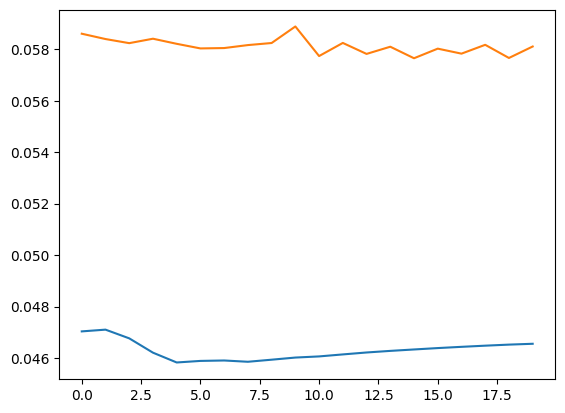

In [52]:
plt.plot(s)
plt.plot(speeds)

### - get the video

In [53]:
p = '/master/tests/data/comcomparing_1_stepp.mp4'
vidParams = disp.videoParameters(p)
import cv2

def compareVideo(data, ground_truth, video_params, bounds=None):
    """
    Creates an MP4 video from a PyTorch tensor representing cell movements using cv2,
    and includes ground truth data visualized in a different color.

    Parameters:
    - data: A PyTorch tensor of shape [T, N, 2], where T is the number of timesteps,
            N is the number of cells, and 2 corresponds to the coordinates (x, y).
    - ground_truth: A PyTorch tensor of shape [T, N, 2], same format as data, representing the ground truth.
    - video_params: An instance of videoParameters class containing video settings.
    - bounds: Tuple of ((min_x, max_x), (min_y, max_y)) specifying the bounds for the positions.
              If None, it uses the minimum and maximum values from the data.
    """
    
    if bounds:
        min_x, max_x = bounds[0]
        min_y, max_y = bounds[1]
    else:
        min_x, max_x = min(data.min(), ground_truth.min()), max(data.max(), ground_truth.max())
        min_y, max_y = min(data.min(), ground_truth.min()), max(data.max(), ground_truth.max())

    # Normalize coordinates to fit within the video frame size
    data[:, :, 0] = (data[:, :, 0] - min_x) / (max_x - min_x) * (video_params.size[0] - 1)
    data[:, :, 1] = (data[:, :, 1] - min_y) / (max_y - min_y) * (video_params.size[1] - 1)
    ground_truth[:, :, 0] = (ground_truth[:, :, 0] - min_x) / (max_x - min_x) * (video_params.size[0] - 1)
    ground_truth[:, :, 1] = (ground_truth[:, :, 1] - min_y) / (max_y - min_y) * (video_params.size[1] - 1)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lowercase
    out = cv2.VideoWriter(video_params.path, fourcc, video_params.fps, video_params.size)

    # Colors (BGR format) and radius
    pred_color = (0, 255, 0)  # Green for predictions
    gt_color = (0, 0, 255)  # Red for ground truth

    for i in range(data.shape[0]):
        frame = np.zeros((video_params.size[1], video_params.size[0], 3), dtype=np.uint8)
        
        # Draw ground truth and predictions
        for (x, y), (gt_x, gt_y) in zip(data[i], ground_truth[i]):
            cv2.circle(frame, (int(x), int(y)), radius=5, color=pred_color, thickness=-1)
            cv2.circle(frame, (int(gt_x), int(gt_y)), radius=2, color=gt_color, thickness=-1)
        
        # Draw legend
        cv2.rectangle(frame, (10, 10), (10 + 20, 30), pred_color, -1)  # Prediction color box
        cv2.rectangle(frame, (10, 40), (10 + 20, 60), gt_color, -1)  # Ground truth color box
        cv2.putText(frame, 'Prediction', (35, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(frame, 'Ground Truth', (35, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        out.write(frame)

    out.release()

In [61]:
#compareVideo(out.copy(), data.copy(), vidParams,bounds=((-140, 140), (-140, 140)))
compareVideo(res[:900].copy(), d2[:900].copy(), vidParams,bounds=((-140, 140), (-140, 140)))

In [363]:
p = '/master/tests/data/1_step_color.mp4'
vidParams = disp.videoParameters(p)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def videoColors(data, errors, video_params, bounds=None):
    """
    Creates an MP4 video from a PyTorch tensor representing cell movements using cv2,
    with cell colors indicating error values, based on specified video parameters and position bounds.

    Parameters:
    - data: A PyTorch tensor of shape [T, N, 2], where T is the number of timesteps,
            N is the number of cells, and 2 corresponds to the coordinates (x, y).
    - errors: A PyTorch tensor of shape [T, N], representing the error of each cell at each timestep.
    - video_params: An instance of videoParameters class containing video settings.
    - bounds: Tuple of ((min_x, max_x), (min_y, max_y)) specifying the bounds for the positions.
              If None, it uses the minimum and maximum values from the data.
    """

    if bounds:
        min_x, max_x = bounds[0]
        min_y, max_y = bounds[1]
    else:
        min_x, max_x = data[:, :, 0].min(), data[:, :, 0].max()
        min_y, max_y = data[:, :, 1].min(), data[:, :, 1].max()

    # Normalize coordinates to fit within the video frame size
    data[:, :, 0] = (data[:, :, 0] - min_x) / (max_x - min_x) * (video_params.size[0] - 1)
    data[:, :, 1] = (data[:, :, 1] - min_y) / (max_y - min_y) * (video_params.size[1] - 1)

    # Normalize errors for color mapping
    norm = Normalize(vmin=errors.min(), vmax=errors.max())
    cmap = plt.get_cmap('jet')

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lowercase
    out = cv2.VideoWriter(video_params.path, fourcc, video_params.fps, video_params.size)

    for i in range(data.shape[0]):
        frame = np.zeros((video_params.size[1], video_params.size[0], 3), dtype=np.uint8)
        for idx, (x, y) in enumerate(data[i]):
            color_value = cmap(norm(errors[i, idx]))[:3]  # Get RGB from RGBA
            color = tuple(int(255 * c) for c in color_value[::-1])  # Convert to BGR for OpenCV
            #print(color)
            #print(x)
            #print(y)
            cv2.circle(frame, (int(x), int(y)), radius=5, color=color, thickness=-1)
        out.write(frame)

    out.release()

In [364]:
errors = (out[:900] - data[:900]) ** 2
errors = np.mean(errors, axis = -1)

In [365]:
videoColors(out[:900].copy(), errors.copy(), vidParams,bounds=((-140, 140), (-140, 140)))

### heatmap

In [65]:
errors = (data - out)**2

In [66]:
def heatmap(values, positions, grid_size=(50, 50), plot_size=(8, 6), mode = 'max', display = True):
    """
    Visualizes the mean acceleration at different positions in a heatmap manner.

    Parameters:
    - values: np.array of shape [T, N], representing the acceleration vectors of N cells over T timesteps.
    - positions: np.array of shape [T, N, 2], representing the spatial positions of N cells over T timesteps.
    - grid_size: Tuple representing the dimensions of the grid used to calculate mean values.
    - plot_size: Tuple representing the size of the output plot.
    """
    
    # Flatten the position and acceleration_norms arrays
    flattened_positions = positions.reshape(-1, 2)
    flattened_values = values.flatten()

    # Create a grid
    x_positions, y_positions = flattened_positions[:, 0], flattened_positions[:, 1]
    x_edges = np.linspace(x_positions.min(), x_positions.max(), grid_size[0] + 1)
    y_edges = np.linspace(y_positions.min(), y_positions.max(), grid_size[1] + 1)

    # Digitize the positions to find out which grid cell each belongs to
    x_inds = np.digitize(x_positions, x_edges) - 1
    y_inds = np.digitize(y_positions, y_edges) - 1

    # Accumulate the acceleration norms in their respective grid cells and count the entries
    accumulation_grid = np.zeros(grid_size, dtype=np.float64)
    count_grid = np.zeros(grid_size, dtype=np.int32)

    for x_ind, y_ind, v in zip(x_inds, y_inds, flattened_values):
        if 0 <= x_ind < grid_size[0] and 0 <= y_ind < grid_size[1]:
            if mode == 'mean':
                accumulation_grid[x_ind, y_ind] += v
            elif mode == 'max':
                accumulation_grid[x_ind, y_ind] = max(accumulation_grid[x_ind, y_ind], v)
            elif mode == 'min':
                accumulation_grid[x_ind, y_ind] = min(accumulation_grid[x_ind, y_ind], v)

            count_grid[x_ind, y_ind] += 1


    if display:
        # Avoid division by zero
        if mode == 'mean':
            with np.errstate(divide='ignore', invalid='ignore'):
                mean_acceleration_grid = np.true_divide(accumulation_grid, count_grid)

        else:
            mean_acceleration_grid = accumulation_grid

        if np.any(count_grid == 0):
            mean_acceleration_grid[count_grid == 0] = np.nan  # Set cells with no data to NaN

        # Plotting the heatmap
        plt.figure(figsize=plot_size)
        plt.imshow(mean_acceleration_grid.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto', cmap='jet')
        plt.colorbar(label='Error')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Heatmap of Error')
    

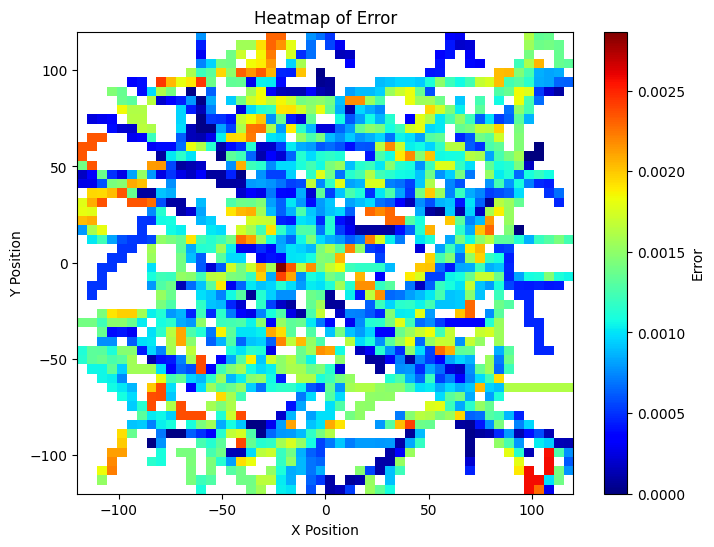

In [67]:
r = heatmap(errors, data, grid_size=(50, 50), plot_size=(8, 6), mode = 'mean', display = True)

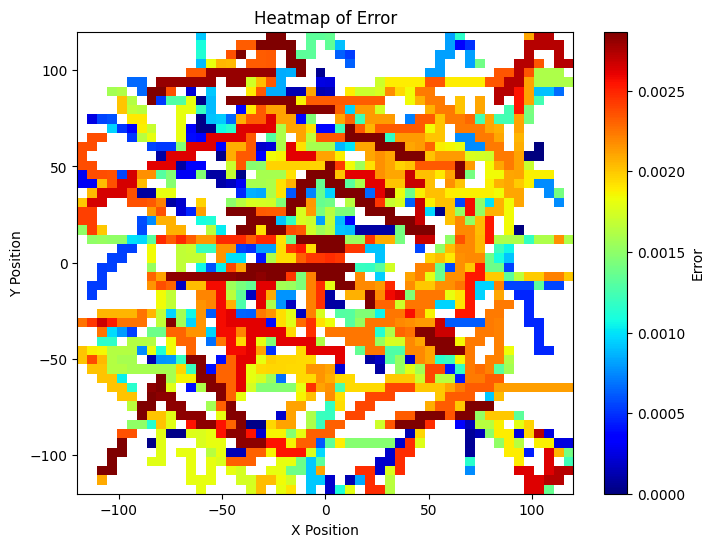

In [68]:
r = heatmap(errors, data, grid_size=(50, 50), plot_size=(8, 6), mode = 'max', display = True)

### =============

In [370]:
def MSE_rollout(roll, sim):
    x = np.arange(roll.shape[0])
    vals = ((roll - sim) ** 2).reshape(x.shape[0], -1)
    y = np.mean(vals, axis=1)
    std = np.std(vals, axis=1)

    plt.plot(x, y, 'blue')
    plt.fill_between(x, y-std, y+std, zorder=  2, alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('Rollout MSE')
    plt.grid(zorder = 1)

    return x, y

(0.0, 0.005)

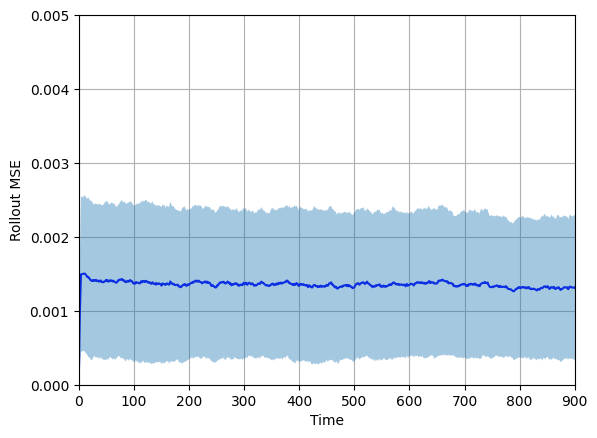

In [371]:
res = MSE_rollout(out, data)
plt.xlim([0, 900])
plt.ylim([0, 0.005])

### MSD

In [372]:
import stats

In [373]:
def MSD_comp(traj, tau):
    T = traj.shape[0]
    i = np.arange(T - tau)
    j = i + tau

    return np.linalg.norm(traj[j, :, :] - traj[i, :, :], axis=-1)**2

def MSD(traj: np.array)-> np.array:
    """
    Allows to compute the Mean Squared Displacement of the trajectories for all timestamps
    
    Args:
    -----
    - `traj`: np.array of N trajectories of length T [NxT]
    
    Output:
    -------
    Mean Squared Displacement for all timestamps
    """

    res = []
    T = traj.shape[0]
    
    for tau in range(1, T):
        val = np.mean(np.mean(MSD_comp(traj, tau), axis=0), axis=0)
        res.append(val)

    return res

def applyMSD(sims:list, dislpay:bool = True, color:str = 'blue')->np.array:
    """ 
    Function to apply MSD to a group of simulations

    NOTE: test

    Args:
    -----
        - `sims` (list): list of simualtions

    Returns:
    --------
        np array [#Sim, T-1] of MSD computations
    """

    res = np.zeros((len(sims), sims[0].shape[0]-1))
    for i in range(len(sims)):
        sim = sims[i]
        res[i, :] = np.array(MSD(sim))


    if dislpay:
        x = np.arange(sims[0].shape[0]-1)
        y = np.mean(res, axis = 0)
        std = np.std(res, axis = 0)
        plt.plot(x, y, color = color, zorder = 1)
        #plt.fill_between(x, y - std, y+std, color = 'red', alpha = 0.4, zorder = 2)
        

    return res

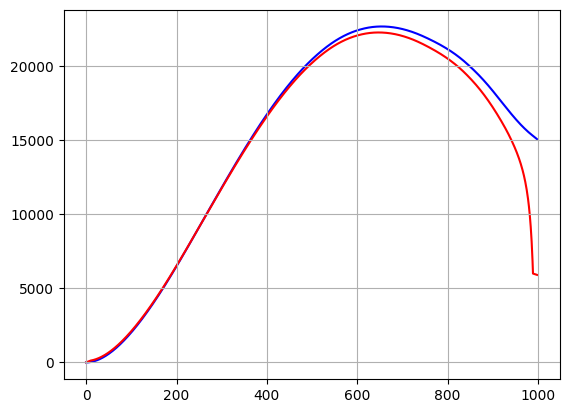

In [374]:
a = applyMSD([data], True)
b = applyMSD([out], True, color = 'red')
plt.grid()

plt.show()

In [219]:
def scaleMagnVel(sim:np.array, bins:np.array, bins2:np.array, display:bool = True)->np.array:
    """ 
    Fucntion to compute the velocity maginutude distr

    Args:
    -----
        - `sim`: simulatioon 
        - `bins`: bins array
        - `bins2`: component histogram bins

    Returns:
    --------
        the tuple of velocities magnitude and components
    """

    # get the velocits

    inds0 = np.arange(sim.shape[0]-1)
    inds = inds0 + 1

    speeds = sim[inds] - sim[inds0]
    vmagn = np.linalg.norm(speeds, axis=-1)
    vx = speeds[:, :, 0]
    vy = speeds[:, :, 1]

    # average speed according to the cells
    avgSpeed = np.mean(vmagn, axis = -1)


    # intitialize the three histograms

    magnDist = np.zeros(len(bins)-1)
    magnDistX = np.zeros(len(bins2)-1)
    magnDistY = np.zeros(len(bins2)-1)


    # loop over cells
    for i in range(speeds.shape[0]):
                
        vdist,_=np.histogram(vmagn[i, :]/avgSpeed[i],bins,density=True)
        magnDist += vdist

        vdistx,_=np.histogram(vx[i, :]/avgSpeed[i],bins2,density=True)
        magnDistX += vdistx


        vdisty,_=np.histogram(vy[i, :]/avgSpeed[i],bins2,density=True)
        magnDistY += vdisty
    
    magnDist = magnDist/speeds.shape[0]
    magnDistX = magnDistX/speeds.shape[0]
    magnDistY = magnDistY/speeds.shape[0]
    


    if display:
        fig=plt.figure()
        db=bins[1]-bins[0]
        plt.grid()
        plt.semilogy(bins[1:]-db/2,magnDist,'r.-',lw=2)
        plt.xlabel('v/<v>')
        plt.ylabel('P(frac{v}{<v>})')
        plt.title('Scaled velocity magnitude distribution')

        fig=plt.figure()
        db=bins2[1]-bins2[0]
        plt.grid()
        plt.semilogy(bins2[1:]-db/2,magnDistX,'r.-',lw=2)
        plt.semilogy(bins2[1:]-db/2,magnDistY,'k.-',lw=2)
        plt.xlabel('v/<v>')
        plt.ylabel('$P(fracv/<v>)$')
        plt.title('Scaled velocity component (x & y) distribution')


    return magnDist, magnDistX, magnDistY

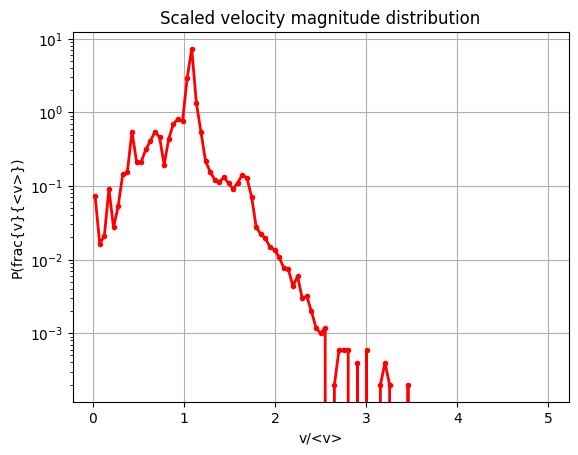

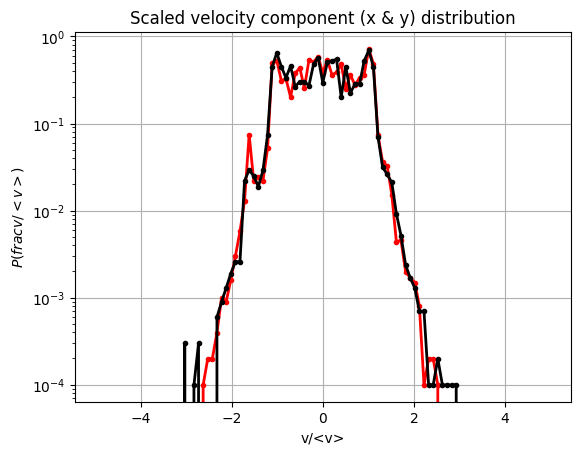

In [224]:
a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)
res = scaleMagnVel(data, a, b)

In [228]:
print(out.shape)
print(data.shape)

(1000, 100, 2)
(1000, 100, 2)


In [230]:
print(out)

[[[ -8.1573174   -6.4755326 ]
  [  9.66396793  -2.96524812]
  [  8.8131778   -4.51966391]
  ...
  [ -9.40695045  -5.68911859]
  [  1.82371428 -11.02456058]
  [ -9.50501506   2.64205487]]

 [[ -8.13160229  -7.69113159]
  [ 10.41846657  -2.04727459]
  [  8.15658188  -3.01830673]
  ...
  [ -9.05066967  -6.65540504]
  [  1.76220036 -12.8708477 ]
  [ -9.65820312   2.69908953]]

 [[ -7.37226343  -8.75876713]
  [ 10.86333942  -0.99794197]
  [  7.17398405  -2.52245855]
  ...
  [-11.00755119  -7.70520592]
  [  2.46740222 -12.69450855]
  [ -8.2700758    1.88701534]]

 ...

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  ...
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.           0.        ]
  [  0.           0.    

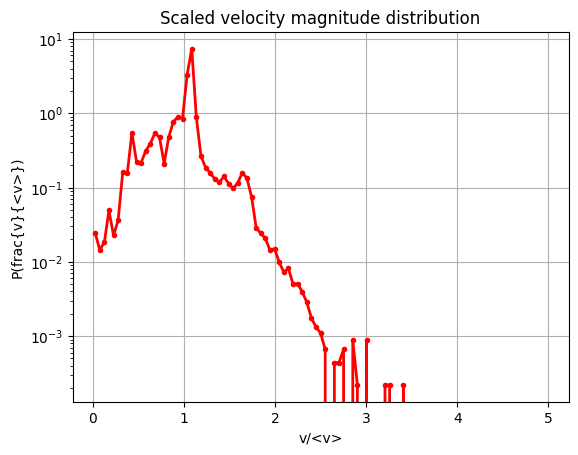

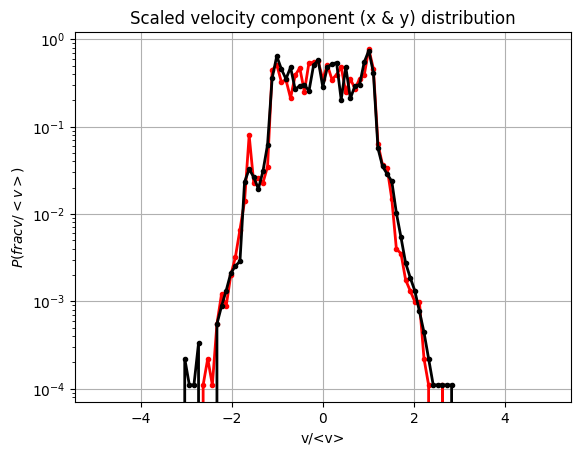

In [231]:
a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)
res = scaleMagnVel(out[:900, :, :], a, b)

### scattering

### -------------

### division angle - norm

In [174]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])
    #angleGT2 = -(v-angleGT)

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)
    #errorAnges2 = np.abs(anglePred - angleGT2)
    #errorAngle = np.minimum(errorAngle, errorAnges2)

    return errorAngle, errorNorm

In [33]:
inds = np.arange(data.shape[0]-1)
inds1 = inds + 1

speeds = data[inds1] - data[inds]
speeds2 = data2[inds1] - data2[inds]

In [34]:
an, no = errorsDiv(speeds[0], speeds2[0])

In [42]:
print(an.shape)
print(np.mean(an))
print(np.std(an))

print(no.shape)
print(np.mean(no))
print(np.std(no))

(100,)
5.0792703376600914e-17
1.5221624302338426e-16
(100,)
1.1102230246251565e-16
2.669157179762418e-16


### distance error

### degree error

In [189]:
def getStdMessage(model, attr):
    model.eval()
    with torch.no_grad():
        v = mod.GNN.message(None, None, attr).cpu().detach().numpy()
    return v



def plotStdMessage(messages):

    std = np.std(messages, axis = 0)

    plt.plot(std)
    plt.xlabel('features')
    plt.ylabel('Standard Deviation')

    return std


In [207]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.utils import degree as deg

mod.eval()

distList = []
errorList = []
degreeList = []
normError = []
angleError = []
messages = None
x, y, attr, inds = ft.processSimulation(data)
with torch.no_grad():
    for i in tqdm(range(len(x))):
        s = Data(x = x[i][:, 2:], y = y[i], edge_index = inds[i], edge_attr = attr[i]).to(DEVICE)

        degs = deg(s.edge_index[0, :], num_nodes=s.x.size(0))

        pred = mod(s)

        errorAngle, errorNorm = errorsDiv(pred.cpu().numpy(), s.y[:, 0, :].cpu().numpy())
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


        errors = torch.mean(torch.abs(pred - s.y[:, 0, :]),dim = -1)      # [N]

        dist = s.edge_attr[:, 0]        # [N]

        distList.extend(dist.cpu().numpy().tolist())  
        errorList.extend(errors.cpu().numpy().tolist())
        degreeList.extend(degs.cpu().numpy().tolist())

        m = getStdMessage(mod, s.edge_attr)
        if messages is None:
            messages = m

        else:
            messages = np.vstack((messages, m))
    
distList = np.array(distList)
errorList = np.array(errorList)
degreeList = np.array(degreeList)
normError = np.array(normError)
angleError = np.array(angleError)







100%|██████████| 989/989 [00:19<00:00, 50.07it/s] 


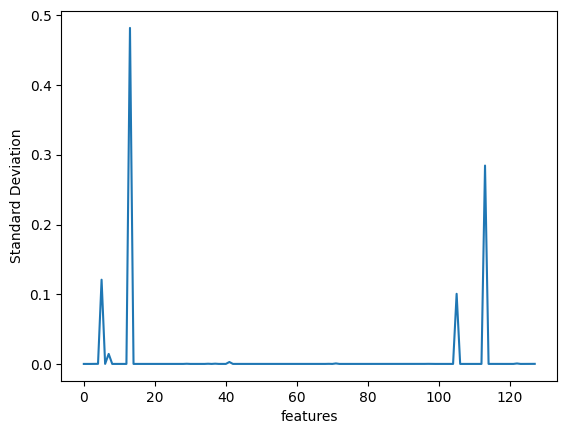

In [208]:
plotStdMessage(messages)
plt.show()

In [209]:
aError = 180 * angleError / np.pi

print(np.median(aError))
print(np.std(aError))

2.9988901777424783
16.818191963840473


In [210]:
print(s.y)

tensor([[[-0.0221,  0.0558],
         [-0.0221,  0.0558],
         [-0.0221,  0.0558],
         ...,
         [-0.0221,  0.0558],
         [-0.0221,  0.0558],
         [-0.0221,  0.0558]],

        [[ 0.0409,  0.0439],
         [ 0.0409,  0.0439],
         [ 0.0409,  0.0439],
         ...,
         [ 0.0409,  0.0439],
         [ 0.0409,  0.0439],
         [ 0.0409,  0.0439]],

        [[-0.0204,  0.0564],
         [-0.0204,  0.0564],
         [-0.0204,  0.0564],
         ...,
         [-0.0204,  0.0564],
         [-0.0204,  0.0564],
         [-0.0204,  0.0564]],

        ...,

        [[ 0.0595,  0.0076],
         [ 0.0595,  0.0076],
         [ 0.0595,  0.0076],
         ...,
         [ 0.0595,  0.0076],
         [ 0.0595,  0.0076],
         [ 0.0595,  0.0076]],

        [[ 0.0194, -0.0568],
         [ 0.0194, -0.0568],
         [ 0.0194, -0.0568],
         ...,
         [ 0.0194, -0.0568],
         [ 0.0194, -0.0568],
         [ 0.0194, -0.0568]],

        [[-0.0595,  0.0075],
       

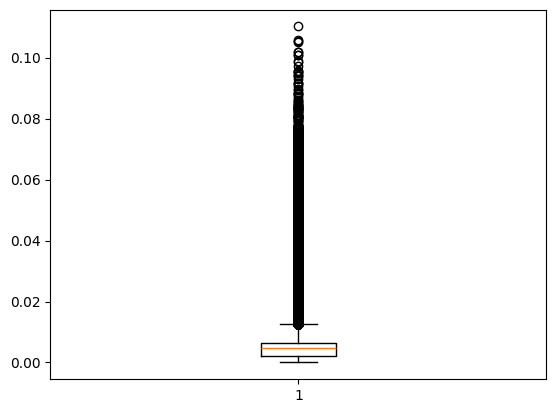

In [211]:
plt.boxplot(normError)
plt.show()

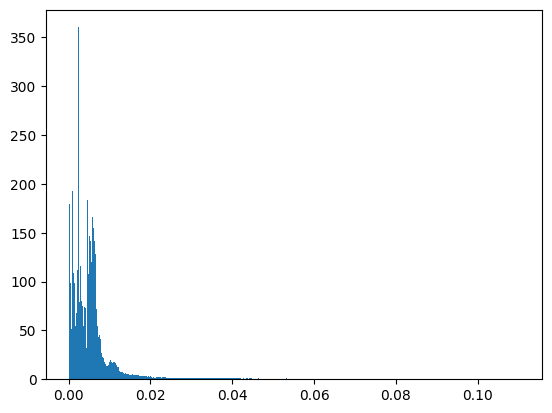

In [212]:
plt.hist(normError, bins='auto',density = True)
plt.show()

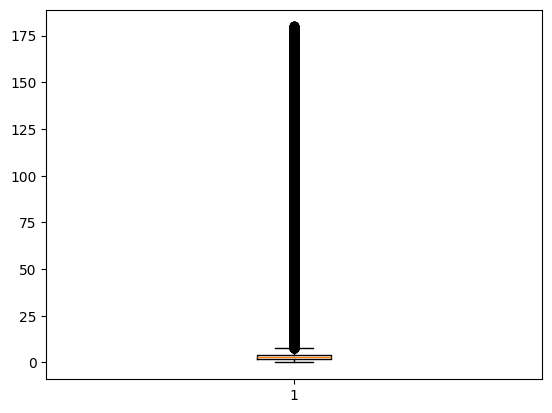

In [213]:
plt.boxplot(aError)
plt.show()

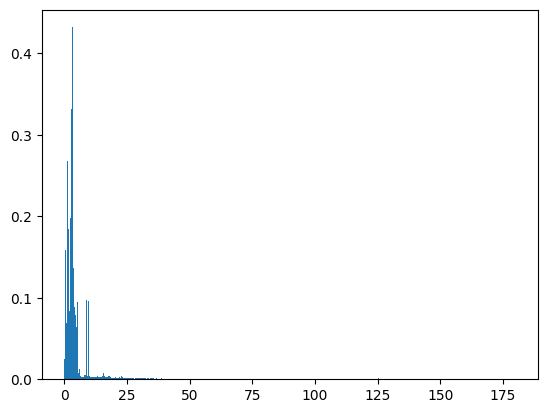

In [214]:
plt.hist(aError, density = True, bins = 'auto')
plt.show()

In [215]:
print(np.median(normError))
print(np.std(normError))

0.004763532429933548
0.007997567661377842


In [216]:
def plotBoxPlot(diff, vals, bins, xlabel = 'X values', ylabel = 'y values', showfliers = False):

    groups = np.digitize(diff, bins)
    grouped_errors = {i: [] for i in range(1, len(bins))}

    for idx, group in enumerate(groups):
        grouped_errors[group].append(vals[idx])

    
    centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    data_to_plot = [grouped_errors[k] for k in sorted(grouped_errors.keys())]
    medians = [np.median(g) if g else 0 for g in data_to_plot]

    boxprops = dict(linestyle='-', linewidth=2, color='black')  # Custom box properties
    medianprops = dict(linestyle='-', linewidth=0, color='orange')  # Invisible median line
    boxplot_elements = plt.boxplot(data_to_plot, positions=centers, boxprops=boxprops, medianprops=medianprops, showfliers=showfliers, widths = 0.2)

    plt.plot(centers, medians, 'o-', color='orange', label='Medians')


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return medians

In [217]:
print(max(degreeList))

5.0


In [218]:
print(bins)

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5]


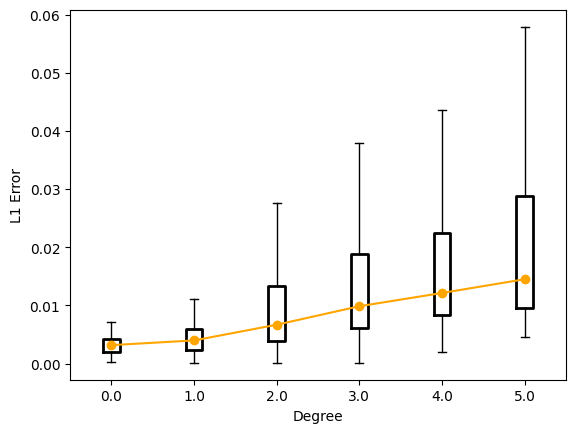

In [219]:
bins = np.arange(7) - 0.5
plotBoxPlot(degreeList, errorList, bins, xlabel = 'Degree', ylabel = 'L1 Error')
plt.show()

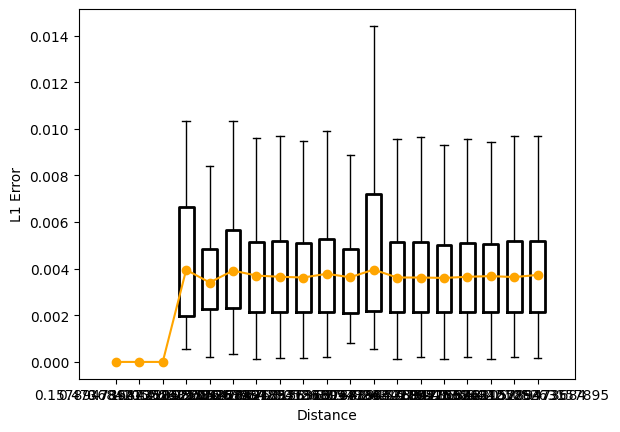

In [220]:
bins = np.linspace(0, 6, 20)
plotBoxPlot(distList, errorList, bins, xlabel = 'Distance', ylabel = 'L1 Error')
plt.show()

In [ ]:
bins = np.linspace(0, 6, 20)
plotBoxPlot(distList, errorList, bins)
plt.show()

In [81]:
print(distances)
print(groups)

[  0 179  92  14 106  71 188  20 102 121  74  87 116  99 103 151 130 149
  52   1  87 157  37 129 191 187  20 160  57  21  88  48  58 169 187  14
 189 189 174 189  50 107  54  63 130  50 134  20  72 166  17 131  88  59
  13   8  89  52 129  83  91 110 187 198 171   7 174  34  80 163  49 103
 131   1 133  53 105   3  53 190 145  43 161 189  13  94  47  14 199 189
  39  81 110  52  23 153 187 123  40 156]
[1 9 5 1 5 4 9 1 5 6 4 4 6 5 5 7 6 7 3 1 4 8 2 6 9 9 1 8 3 1 4 3 3 8 9 1 9
 9 8 9 3 5 3 3 6 3 7 1 4 8 1 6 4 3 1 1 5 3 6 4 5 5 9 9 8 1 8 2 4 8 3 5 6 1
 6 3 5 1 3 9 7 2 8 9 1 5 3 1 9 9 2 4 5 3 2 7 9 6 2 8]


### L1 vect

In [240]:
for n, p in mod.GNN.named_parameters():
    print(f'{n} >>>>  {p.shape}')

messageMLP.mlp.0.weight >>>>  torch.Size([128, 5])
messageMLP.mlp.0.bias >>>>  torch.Size([128])
messageMLP.mlp.3.weight >>>>  torch.Size([128, 128])
messageMLP.mlp.3.bias >>>>  torch.Size([128])
messageMLP.mlp.6.weight >>>>  torch.Size([128, 128])
messageMLP.mlp.6.bias >>>>  torch.Size([128])
norm.weight >>>>  torch.Size([128])
norm.bias >>>>  torch.Size([128])
updateMLP.mlp.0.weight >>>>  torch.Size([172, 256])
updateMLP.mlp.0.bias >>>>  torch.Size([172])
updateMLP.mlp.3.weight >>>>  torch.Size([88, 172])
updateMLP.mlp.3.bias >>>>  torch.Size([88])
updateMLP.mlp.6.weight >>>>  torch.Size([2, 88])
updateMLP.mlp.6.bias >>>>  torch.Size([2])


In [249]:
print(mod.GNN)

GN_edge()


In [255]:
x, y, attr, inds = processSimulation(data)

vect = None

for t in range(len(x)):

    a = attr[t].to(DEVICE)

    if vect is None:
        vect = mod.GNN.message(None, None, a).cpu().unsqueeze(dim = 0)
        print(vect.shape)

    else:
        vect = torch.stack((vect,mod.GNN.message(None, None, a).cpu().unsqueeze(dim = 0)), dim = 0)
        print(vect.shape)




torch.Size([1, 1716, 128])


RuntimeError: stack expects each tensor to be equal size, but got [1, 1716, 128] at entry 0 and [1, 1536, 128] at entry 1

In [267]:
std = torch.load('/master/code/models/cramner_best2.pt')
mod.load_state_dict(std)
mod.eval()

SimpleMod(
  (enc): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=8, out_features=48, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=48, out_features=88, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=88, out_features=128, bias=True)
    )
  )
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (GNN): GN_edge()
)

In [200]:
a = attr[0].to(DEVICE)

In [201]:
mod.eval()
with torch.no_grad():
    v = mod.GNN.message(None, None, a).cpu().detach().numpy()

In [272]:
a2 = a.cpu().numpy()

In [202]:
values = np.std(v,axis = 0)

In [ ]:
def getStdMessage(model, attr):
    model.eval()
    with torch.no_grad():
        v = mod.GNN.message(None, None, attr).cpu().detach().numpy()
    return v



def plotStdMessage(messages):

    std = np.std(v, axis = 0)

    plt.plot(std)
    plt.xlabel('features')
    plt.ylabel('Standard Deviation')

    return std


In [ ]:
def getStdMessage(model, attr):
    model.eval()
    with torch.no_grad():
        v = mod.GNN.message(None, None, attr).cpu().detach().numpy()
    std = np.std(v, axis = 0)

    plt.plot(std)
    plt.xlabel('features')
    plt.ylabel('Standard Deviation')

    return std

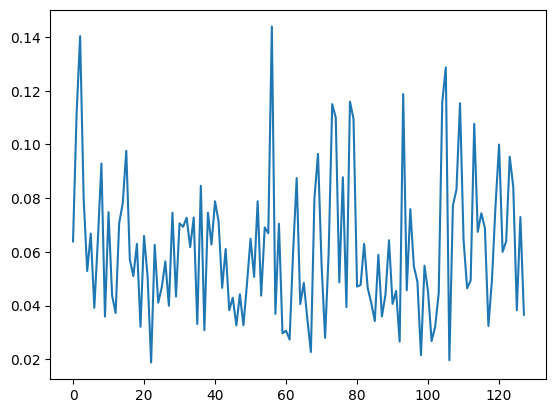

In [203]:
plt.plot(values)

In [276]:
os.path.exists('/master/code')

True

In [286]:
inds = np.argsort(values)
print(inds)

[ 33  67  86  26 124  81 117  49   9 110  70  90   2  66   0  48  16  30
 111  39 123  73  20  76  51  93  61 109  57 104  56 112 115  12  46   8
  54  94  19  36  75  78  91 106  62 102 126  47  72  77  79 125  99  14
  18 119  31  45  28  58  40  34  11  74  50  64  82 108  25  53  87  21
  85 121  15  80  60  92 118  42 101 116  27   6  24  52  10  68  38   3
  84 120  59  32  65  83  43  22  55  23 114  63 103  95  89  96  98  88
 107  17  44   1 100 127   4  97  69  29  35  37 122  71  41   7 105   5
 113  13]


In [289]:
print(values[inds[-4:]])

[0.10199607 0.16727437 0.35626298 0.5089267 ]


In [279]:
os.listdir('/master/tests')

['data',
 'launch_simulations_test.ipynb',
 'pySr_test.ipynb',
 'test_features.ipynb',
 'test_measures.ipynb',
 'test_sim.ipynb']

In [292]:
print(v.shape)

(1536, 128)


In [291]:
np.save('/master/tests/messages', a2)
np.save('/master/tests/feats', v[:, inds[-4:]])

### impact of teh degree 

In [ ]:
d = {}
degMax = 20
for i in range(degMax):
    d[i] = []


def getErrorDegree(graph, errors, d,degMax = 15):

    degrees = deg(graph.edge_index[0], num_nodes=graph.x.size(0))
    
    for i in range(degMax):
        inds = degree == i

        d[i].appned(errors[inds])

    return d


#s = Data(x = x[0], edge_index = inds[0], edge_attr = attr[0])

#d = getErrorDegree(s, errors, d,degMax = 15)

def plotDistanceError(d, max_deg = 15, display:bool = True):
    x = np.arange(max_deg) 
    y= []
    std = []
    for i in range(max_deg):
        y.append(np.mean(d[i]))
        std.append(np.std(d[i]))

    if display:
        plt.plot(x, y)
        # fill between

    return x, y

### importance of the distance